# Deep Learning
## Udacity course Assignment 1: notMNIST

We'll be completing and showing our code solution for the problems presented in [assignment 1](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/udacity/1_notmnist.ipynb).

I'll be maintaining a separate script that contains the same functionality in case you don't want to use jupyter/python notebook.

In [1]:
# dependencies we'll need for this assignment
# you can install the necessary libraries by running pip install -r requirements.txt
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# setup matplotlib to plot inline in jupyter
%matplotlib inline

To get started we'll need to download (part of) the notMNIST dataset on our machine. For more, details about the dataset please visit the linked assignment page at the top. We'll be running this code to download the dataset. 

In [2]:
#provided script for downloading datasets

url = 'http://commondatastorage.googleapis.com/books1000/' #dataset URL
last_percent_reported = None 

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()

    last_percent_reported = percent

def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename)
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


If our code runs correctly you should see the following output:

`Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz`

Next, we'll be extracting the dataset tars we downloaded:

In [3]:
#extract the dataset tars we download into A-J directories (for each class). we'll have two datasets

num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders

train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


We should see this output:

`['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']`

## Problem 1:

For this problem we need to display a sample data image from each of the classes we downloaded. We need to take a look at our data to make sure it looks sensible

In [4]:
"""function for displaying a random photo from each class in a dataset"""
def display_samples(dataset_folders):
    # go through each class in the dataset
    for folder in dataset_folders:
        imgs = os.listdir(folder) # list all images in a class
        sample = folder + '/' + imgs[np.random.randint(len(imgs))] # path for a random image from a dataset class
        #print(sample)
        display(Image(sample)) # display our sample

print("Here's a random sample from each class in the training dataset:")
display_samples(train_folders)

print("Here's a random sample from each class in the testing dataset:")
display_samples(test_folders)


Here's a random sample from each class in the training dataset:


Here's a random sample from each class in the testing dataset:


Dealing with all these images at a time would be incredibly taxing on our machine. We'll be storing each class in a manageable data structure so we can work with them. We'll be using python's object serialization module, pickle. You can read more about it [here](https://docs.python.org/3/library/pickle.html):

In [5]:
"""now that we've each extracted the dataset and their respective classes, we'll load and store them them into a manageable format
so we can deal with them with an average computer. we'll store each class on disk, deal with them independently, and merge them into
a single dataset when we're done processing/training with them. we'll convert the entire dataset into a float 3D array [image_index, x, y].
The dataset will be initialized to have ~0 mean and a std dev of ~0.5 (so we initially have relatively uncertain results from our trained classifier)
Some errors may occur reading some images, but we'll ignore them. """

image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) -
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')

  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))

  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset

def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)

  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800) 

notMNIST_large/A.pickle already present - Skipping pickling.
notMNIST_large/B.pickle already present - Skipping pickling.
notMNIST_large/C.pickle already present - Skipping pickling.
notMNIST_large/D.pickle already present - Skipping pickling.
notMNIST_large/E.pickle already present - Skipping pickling.
notMNIST_large/F.pickle already present - Skipping pickling.
notMNIST_large/G.pickle already present - Skipping pickling.
notMNIST_large/H.pickle already present - Skipping pickling.
notMNIST_large/I.pickle already present - Skipping pickling.
notMNIST_large/J.pickle already present - Skipping pickling.
notMNIST_small/A.pickle already present - Skipping pickling.
notMNIST_small/B.pickle already present - Skipping pickling.
notMNIST_small/C.pickle already present - Skipping pickling.
notMNIST_small/D.pickle already present - Skipping pickling.
notMNIST_small/E.pickle already present - Skipping pickling.
notMNIST_small/F.pickle already present - Skipping pickling.
notMNIST_small/G.pickle 

## Problem 2:
Let's take a look at our pickle dataset structure and display some samples to make sure everything's ok.

In [6]:
def pickle_samples(dataset_folders):
    #plt.gcf().clear() # clear plt for multiple uses. Kind of weird I encountered this behaviour
    
    class_folder = np.random.choice(dataset_folders) # get 1 random folder from dataset folders
    pickle_path = class_folder + '.pickle'
    pickle_class = ''
    if (os.path.isfile(pickle_path)):
        pickle_class = pickle.load(open(pickle_path, "rb"))
    else:
        print("Error reading dataset %s. Exiting.", pickle_path)
        return -1
    #display our samples:
    plt.suptitle(class_folder[-1]) # display a title for our sample graphs. We'll use the letter of the class
    
    for p_i, img in enumerate(random.sample(list(pickle_class), 5)): #choose 5 random images from our pickled dataset 
        plt.subplot(1, 5, p_i+1)
        plt.axis('off')
        plt.imshow(img)

Let's take a look at our pickled training dataset to check if everything is ok:


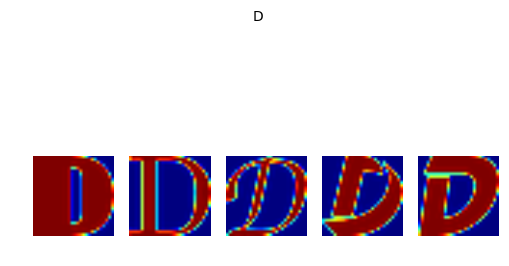

In [7]:
#due to how matplotlib's plots work we have to create a separate cell for each dataset
print("Let's take a look at our pickled training dataset to check if everything is ok:")
pickle_samples(train_folders)

Let's take a look at our pickled test dataset to check if everything is ok:


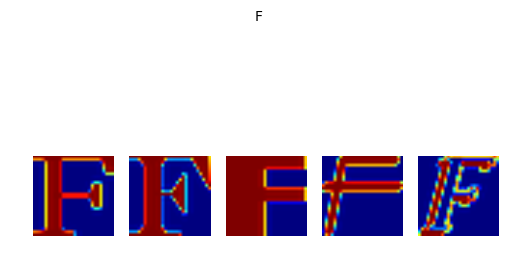

In [8]:
#due to how matplotlib's plots work we have to create a separate cell for each dataset
print("Let's take a look at our pickled test dataset to check if everything is ok:")
pickle_samples(test_folders)

## Problem 3
The datasets we use should be balanced across classes in the dataset (i.e. the classes should have almost the same number of images). Let's confirm:

In [9]:
def class_is_balanced(dataset_folders):
    total = 0
    for cf in dataset_folders:
        pickle_path = cf + '.pickle'
        if (os.path.isfile(pickle_path)):
            pickle_class = pickle.load(open(pickle_path, "rb"))
        else:
            print("Error reading dataset %s. Exiting.", pickle_path)
            return -1
        print("The total number of images in class %s is: %d" % (cf, len(pickle_class)))
        total += len(pickle_class)
    print("For the dataset to be balanced, each class should have approximately %d images.\n" % (total / len(dataset_folders)))
    
print("Let's see if the training dataset is balanced:")
class_is_balanced(train_folders)

print("Let's see if the testing dataset is balanced:")
class_is_balanced(test_folders)

Let's see if the training dataset is balanced:
The total number of images in class notMNIST_large/A is: 52909
The total number of images in class notMNIST_large/B is: 52911
The total number of images in class notMNIST_large/C is: 52912
The total number of images in class notMNIST_large/D is: 52911
The total number of images in class notMNIST_large/E is: 52912
The total number of images in class notMNIST_large/F is: 52912
The total number of images in class notMNIST_large/G is: 52912
The total number of images in class notMNIST_large/H is: 52912
The total number of images in class notMNIST_large/I is: 52912
The total number of images in class notMNIST_large/J is: 52911
For the dataset to be balanced, each class should have approximately 52911 images.

Let's see if the testing dataset is balanced:
The total number of images in class notMNIST_small/A is: 1872
The total number of images in class notMNIST_small/B is: 1873
The total number of images in class notMNIST_small/C is: 1873
The tot

If your dataset is balanced (each class is very close to all the others) then we can continue.

Next up we're going to merge and prune our datasets. You may need to adjust the size of the training data depending on the capabilities of your computer. Labels will be stored in a separate integer array of 0 through 9.

In [10]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0): # valid_size is 0 if not given as argument. 
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f) #open a pickle of a training set
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set) # shuffle the data (the "images") in the pickle around 
        if valid_dataset is not None: # if not testing dataset 
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label # give label to all images in class
        start_t += tsize_per_class # offset start of class for next iteration 
        end_t += tsize_per_class # offset end of class for next iteration
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
# the number of images in our training, validation, and testing dataset respectively
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size) #valid_size will be zero. 

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [11]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

## Problem 4:
We'll need to confirm the data is still valid after being shuffled.

In [12]:

def sampleCheck(dataset, labels):
    i = random.randint(1, 5)
    print("Labels: 0 = A, 1 = B, ... 9 = J")
    print("We'll convert these with their ASCII values for easier readability")
    for p_i, img in enumerate(random.sample(range(len(labels)), 5*i)):
        plt.subplot(i, 5, p_i+1)
        plt.axis('off')
        plt.title('label ' + chr(labels[img] + 65))
        plt.imshow(dataset[img])


Labels: 0 = A, 1 = B, ... 9 = J
We'll convert these with their ASCII values for easier readability


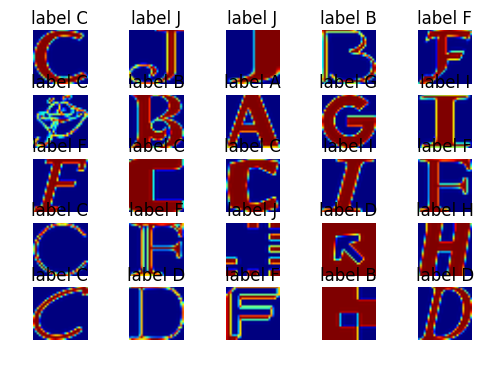

In [13]:
sampleCheck(train_dataset, train_labels)

Labels: 0 = A, 1 = B, ... 9 = J
We'll convert these with their ASCII values for easier readability


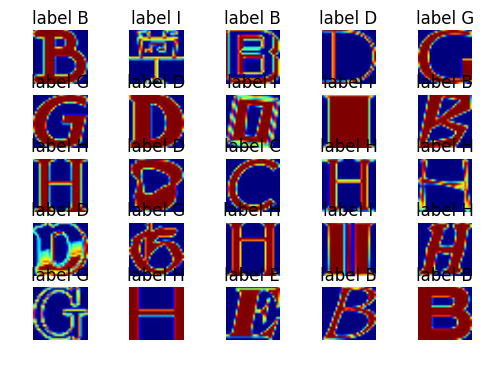

In [14]:
sampleCheck(valid_dataset, valid_labels)

Labels: 0 = A, 1 = B, ... 9 = J
We'll convert these with their ASCII values for easier readability


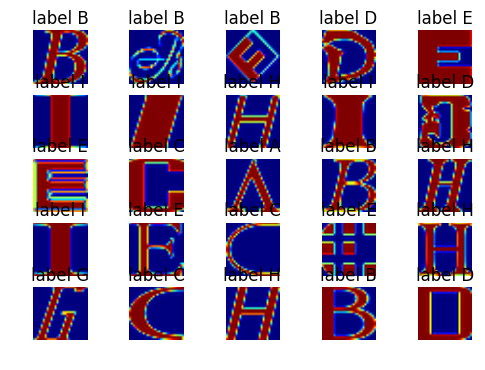

In [15]:
sampleCheck(test_dataset, test_labels)

As you can see, our datasets are still properly labeled. Now let's save our datasets in a pickle for later reuse. 

In [16]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    } 
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL) # save all out datasets in one pickle 
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [17]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size) # check whole dataset pickle exists and its size

Compressed pickle size: 690800512


## Problem 5
By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it. Measure how much overlap there is between training, validation and test samples.

Optional questions:
* What about near duplicates between datasets? (images that are almost identical)
* Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.

In [18]:
def isDup(D1, L1, D2, L2):
    num = len(L1) if len(L1) < len(L2) else len(L2)
    dups = 0
    for img in range(0, num):
        if (np.array_equiv(D1[img], D2[img])):
            dups += 1
    return dups

a = isDup(valid_dataset, valid_labels, test_dataset, test_labels)

print("sample of duplicates between training dataset and valid dataset: ", a)# this is wrong. I need to see how I can do this

sample of duplicates between training dataset and valid dataset:  1


Since Problem 5 isn't completely necessary to complete problem 6 I will skip it for now. Need to investigate ways to compare images and find similar ones.

## Problem 6

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data! (I don't know if laptop can handle. Will try during winter break on my desktop)

A tutorial from sklearn that is very similar to what we're doing can be found [here](http://scikit-learn.org/stable/tutorial/basic/tutorial.html#introduction)

Info about sklearn's Logistic Regression classfier [here](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)

Intro to machine learning with sk learn [here](http://scikit-learn.org/stable/tutorial/basic/tutorial.html#introduction)

More about linear regression [here](https://github.com/justmarkham/DAT4/blob/master/notebooks/08_linear_regression.ipynb)

In [19]:
def classifyScore(n_samples, n_classes, train_dataset, train_labels, test_dataset, test_labels):
    (images, h, w) = train_dataset.shape # get shape of train_dataset np array
    # remember Loss =  1 / N 𝛴_i D(S(WX_i +b), L_i) 
    X = np.reshape(train_dataset, (images, h*w))[:n_samples] # reshape training dataset by vectorizing the images and taking n samples
    y = train_labels[:n_samples] # one hot encoded labels for training dataset
    
    lR = LogisticRegression()
    lR.fit(X, y) # train your logisitc classifier
    
    (images, h, w) = test_dataset.shape
    X_testing = np.reshape(test_dataset, (images, h*w))[:n_samples]
    y_testing = test_labels[:n_samples]
    return lR.score(X_testing, y_testing)

In [20]:
print("Logistic Regression classifier score with sample size of 50: ", classifyScore(50, 10, train_dataset, train_labels, test_dataset, test_labels))
print("Logistic Regression classifier score with sample size of 100: ", classifyScore(100, 10, train_dataset, train_labels, test_dataset, test_labels))
print("Logistic Regression classifier score with sample size of 1000: ", classifyScore(1000, 10, train_dataset, train_labels, test_dataset, test_labels))
print("Logistic Regression classifier score with sample size of 5000: ", classifyScore(5000, 10, train_dataset, train_labels, test_dataset, test_labels))
print("Logistic Regression classifier score with sample size of 10000: ", classifyScore(10000, 10, train_dataset, train_labels, test_dataset, test_labels))
print("Hitting diminishing returns after 10000. Also laptop takes quite a while to train. Need to read more about")
print("sklearn's Linear Regression classifier and see how I can improve my data (maybe eliminate overlaps from problem 5)")

Logistic Regression classifier score with sample size of 50:  0.64
Logistic Regression classifier score with sample size of 100:  0.66
Logistic Regression classifier score with sample size of 1000:  0.831
Logistic Regression classifier score with sample size of 5000:  0.8532
Logistic Regression classifier score with sample size of 10000:  0.8624
Hitting diminishing returns after 10000. Also laptop takes quite a while to train. Need to read more about
sklearn's Linear Regression classifier and see how I can improve my data (maybe eliminate overlaps from problem 5)
